The codes below are adapted from Brain Tumor Detection Using PyTorch written by OMAR KHALED.
We modified the codes to train a similar model for shot_detection_classification
The model has 0.91 accuracy over 50 epochs

https://www.kaggle.com/code/oknashar/brain-tumor-detection-using-pytorch?scriptVersionId=90753009&cellId=15




In [1]:

import numpy as np
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchsummary import summary

from sklearn.metrics import accuracy_score,classification_report

from tqdm import tqdm_notebook as tqdm
import time
import warnings
warnings.simplefilter("ignore")

In [16]:
trainig_path = './data/frames/training'
testing_path = './data/frames/testing'
labels = ['CS', 'ECS', 'FS', 'LS', 'MS']

IMAGE_SIZE=(128,128)
batch_size=64
learning_rate = 0.0008
epochs=50
num_classes=5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

In [17]:
def images_transforms(phase):
    if phase == 'training':
        data_transformation = transforms.Compose([
            transforms.Resize(IMAGE_SIZE),
#             transforms.RandomEqualize(10),
            transforms.RandomRotation(degrees=(-25,20)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
    else:
        data_transformation=transforms.Compose([
            transforms.Resize(IMAGE_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
        
    
    return data_transformation

In [18]:
trainset=datasets.ImageFolder(trainig_path,transform=images_transforms('training'))
testset=datasets.ImageFolder(testing_path,transform=images_transforms('test'))
valset_len = len(testset) - int(0.4 * len(testset))
testset, valset = torch.utils.data.random_split(testset, [int(0.4 * len(testset)), valset_len])

In [19]:
train_loader = DataLoader(trainset,batch_size=batch_size,shuffle=True,num_workers=2)
test_loader = DataLoader(testset,batch_size=batch_size,shuffle=True,num_workers=2)
val_loader = DataLoader(valset,batch_size=batch_size,shuffle=True,num_workers=2)

In [20]:
def imshow(img):
    plt.figure(figsize=(20, 20))
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


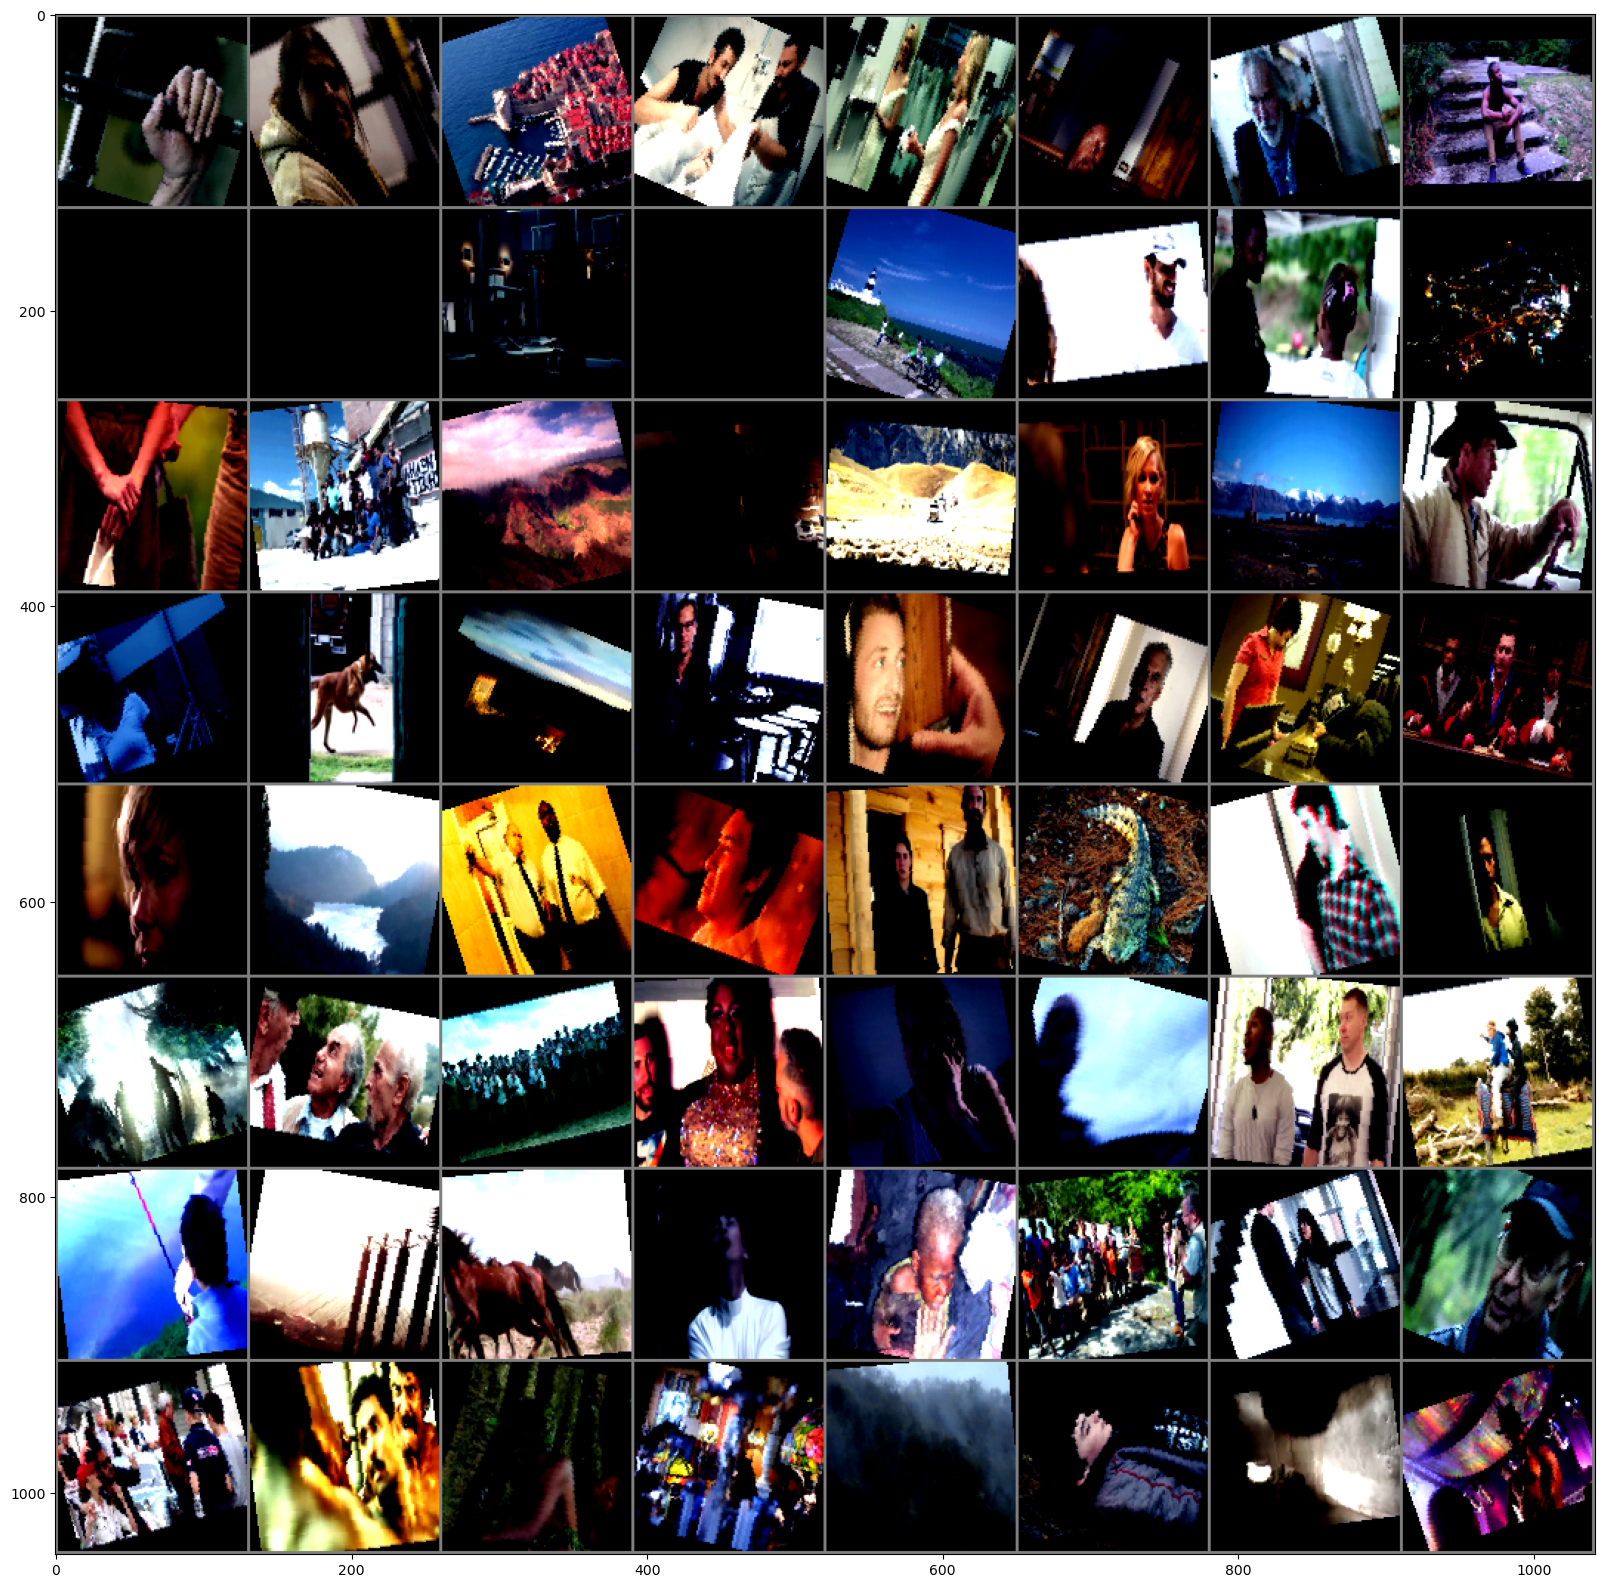

In [21]:
examples = iter(train_loader)
images,labels = next(examples)
imshow(torchvision.utils.make_grid(images))

In [22]:
model=torchvision.models.mobilenet_v3_large(pretrained=True)
num_features=model.classifier[0].in_features
model.classifier=nn.Sequential(
    nn.Linear(in_features=num_features, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=num_classes, bias=True)
  )

In [23]:
model=model.to(device)
criterion=nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(),lr=learning_rate)

In [24]:
IMAGE_SIZE=(3,)+IMAGE_SIZE
print(summary(model,IMAGE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             432
       BatchNorm2d-2           [-1, 16, 64, 64]              32
         Hardswish-3           [-1, 16, 64, 64]               0
            Conv2d-4           [-1, 16, 64, 64]             144
       BatchNorm2d-5           [-1, 16, 64, 64]              32
              ReLU-6           [-1, 16, 64, 64]               0
            Conv2d-7           [-1, 16, 64, 64]             256
       BatchNorm2d-8           [-1, 16, 64, 64]              32
  InvertedResidual-9           [-1, 16, 64, 64]               0
           Conv2d-10           [-1, 64, 64, 64]           1,024
      BatchNorm2d-11           [-1, 64, 64, 64]             128
             ReLU-12           [-1, 64, 64, 64]               0
           Conv2d-13           [-1, 64, 32, 32]             576
      BatchNorm2d-14           [-1, 64,

In [25]:
def test(model,testloader):
    with torch.no_grad():
        n_correct=0
        n_samples=0
        y_pred=[]
        y_actual=[]
        for i,(images,labels) in enumerate(testloader):
            images=images.to(device)
            labels=labels.to(device)
            
            outputs=model(images)
            
            y_actual+=list(np.array(labels.detach().to('cpu')).flatten())
        # value ,index
            _,predictes=torch.max(outputs,1)
            y_pred+=list(np.array(predictes.detach().to('cpu')).flatten())
        # number of samples in current batch
            n_samples+=labels.shape[0]

            n_correct+= (predictes==labels).sum().item()
            
        y_actual=np.array(y_actual).flatten()
        y_pred=np.array(y_pred).flatten()
        print(np.unique(y_pred))
        acc = classification_report(y_actual,y_pred,target_names=trainset.classes)
        print(f"{acc}")

def train(model,train_loader,criterion,optimizer,val_loader,epochs=25):
    train_losses = []
    val_losses = []
    train_auc = []
    val_auc = []
    train_auc_epoch = []
    val_auc_epoch = []
    best_acc = 0.0
    min_loss = np.Inf

    since = time.time()
    y_actual=[]
    y_pred=[]
    for e in range(epochs):
        y_actual=[]
        y_pred=[]
        train_loss = 0.0
        val_loss = 0.0

        # Train the model
        model.train()
        for i, (images, labels) in enumerate(tqdm(train_loader, total=int(len(train_loader)))):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss and accuracy
            train_loss += loss.item()
            
            _,predictes=torch.max(outputs,1)
            y_actual += list(labels.data.cpu().numpy().flatten()) 
            y_pred += list(predictes.detach().cpu().numpy().flatten())
        train_auc.append(accuracy_score(y_actual, y_pred))

        # Evaluate the model
        model.eval()
        for i, (images, labels) in enumerate(tqdm(val_loader, total=int(len(val_loader)))):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Loss and accuracy
            val_loss += loss.item()
            _,predictes=torch.max(outputs,1)
            y_actual += list(labels.data.cpu().numpy().flatten()) 
            y_pred += list(predictes.detach().cpu().numpy().flatten())
        
        val_auc.append(accuracy_score(y_actual, y_pred))

        # Average losses and accuracies
        train_loss = train_loss/len(train_loader)
        val_loss = val_loss/len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        training_auc = train_auc[-1]
        validation_auc = val_auc[-1]
        train_auc_epoch.append(training_auc)
        val_auc_epoch.append(validation_auc)

        # Updating best validation accuracy
        if best_acc < validation_auc:
            best_acc = validation_auc

        # Saving best model
        if min_loss >= val_loss:
            torch.save(model.state_dict(), 'best_model.pt')
            min_loss = val_loss

        print('EPOCH {}/{} Train loss: {:.6f},Validation loss: {:.6f}, Train AUC: {:.4f}  Validation AUC: {:.4f}\n  '.format(e+1, epochs,train_loss,val_loss, training_auc,validation_auc))
        print('-' * 10)
    time_elapsed = time.time() - since
    print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best validation accuracy: {:4f}'.format(best_acc))
    return train_losses,val_losses,train_auc ,val_auc,train_auc_epoch,val_auc_epoch

In [26]:
train_losses,val_losses,train_auc ,val_auc,train_auc_epoch,val_auc_epoch=train(model,train_loader,criterion,optimizer,val_loader,epochs)

  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 1/50 Train loss: 0.558277,Validation loss: 0.416036, Train AUC: 0.7879  Validation AUC: 0.7953
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 2/50 Train loss: 0.378315,Validation loss: 0.355383, Train AUC: 0.8597  Validation AUC: 0.8615
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 3/50 Train loss: 0.279820,Validation loss: 0.355223, Train AUC: 0.8978  Validation AUC: 0.8953
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 4/50 Train loss: 0.228123,Validation loss: 0.356744, Train AUC: 0.9179  Validation AUC: 0.9132
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 5/50 Train loss: 0.178923,Validation loss: 0.356799, Train AUC: 0.9348  Validation AUC: 0.9291
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 6/50 Train loss: 0.148543,Validation loss: 0.394078, Train AUC: 0.9448  Validation AUC: 0.9381
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 7/50 Train loss: 0.132844,Validation loss: 0.365931, Train AUC: 0.9519  Validation AUC: 0.9440
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 8/50 Train loss: 0.106689,Validation loss: 0.404148, Train AUC: 0.9593  Validation AUC: 0.9508
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 9/50 Train loss: 0.097043,Validation loss: 0.469953, Train AUC: 0.9631  Validation AUC: 0.9545
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 10/50 Train loss: 0.095761,Validation loss: 0.409751, Train AUC: 0.9649  Validation AUC: 0.9561
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 11/50 Train loss: 0.081750,Validation loss: 0.473483, Train AUC: 0.9690  Validation AUC: 0.9597
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 12/50 Train loss: 0.071897,Validation loss: 0.484911, Train AUC: 0.9724  Validation AUC: 0.9631
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 13/50 Train loss: 0.072291,Validation loss: 0.462624, Train AUC: 0.9717  Validation AUC: 0.9622
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 14/50 Train loss: 0.070731,Validation loss: 0.450954, Train AUC: 0.9738  Validation AUC: 0.9644
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 15/50 Train loss: 0.069714,Validation loss: 0.487293, Train AUC: 0.9735  Validation AUC: 0.9645
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 16/50 Train loss: 0.070322,Validation loss: 0.501598, Train AUC: 0.9740  Validation AUC: 0.9637
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 17/50 Train loss: 0.063420,Validation loss: 0.504695, Train AUC: 0.9755  Validation AUC: 0.9660
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 18/50 Train loss: 0.060156,Validation loss: 0.509707, Train AUC: 0.9760  Validation AUC: 0.9669
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 19/50 Train loss: 0.057851,Validation loss: 0.484205, Train AUC: 0.9774  Validation AUC: 0.9677
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 20/50 Train loss: 0.065497,Validation loss: 0.524917, Train AUC: 0.9771  Validation AUC: 0.9671
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 21/50 Train loss: 0.053797,Validation loss: 0.551189, Train AUC: 0.9793  Validation AUC: 0.9691
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 22/50 Train loss: 0.049729,Validation loss: 0.541421, Train AUC: 0.9806  Validation AUC: 0.9705
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 23/50 Train loss: 0.052351,Validation loss: 0.542055, Train AUC: 0.9805  Validation AUC: 0.9705
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 24/50 Train loss: 0.049820,Validation loss: 0.569038, Train AUC: 0.9806  Validation AUC: 0.9703
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 25/50 Train loss: 0.050793,Validation loss: 0.522647, Train AUC: 0.9798  Validation AUC: 0.9697
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 26/50 Train loss: 0.051479,Validation loss: 0.552478, Train AUC: 0.9799  Validation AUC: 0.9703
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 27/50 Train loss: 0.053556,Validation loss: 0.548560, Train AUC: 0.9796  Validation AUC: 0.9697
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 28/50 Train loss: 0.048602,Validation loss: 0.578616, Train AUC: 0.9805  Validation AUC: 0.9704
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 29/50 Train loss: 0.046480,Validation loss: 0.605457, Train AUC: 0.9814  Validation AUC: 0.9714
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 30/50 Train loss: 0.053607,Validation loss: 0.610776, Train AUC: 0.9805  Validation AUC: 0.9702
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 31/50 Train loss: 0.045282,Validation loss: 0.568658, Train AUC: 0.9827  Validation AUC: 0.9726
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 32/50 Train loss: 0.040993,Validation loss: 0.641216, Train AUC: 0.9830  Validation AUC: 0.9731
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 33/50 Train loss: 0.041701,Validation loss: 0.621579, Train AUC: 0.9832  Validation AUC: 0.9729
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 34/50 Train loss: 0.045747,Validation loss: 0.604062, Train AUC: 0.9818  Validation AUC: 0.9715
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 35/50 Train loss: 0.044561,Validation loss: 0.606799, Train AUC: 0.9822  Validation AUC: 0.9720
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 36/50 Train loss: 0.051861,Validation loss: 0.599498, Train AUC: 0.9825  Validation AUC: 0.9722
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 37/50 Train loss: 0.041553,Validation loss: 0.623682, Train AUC: 0.9833  Validation AUC: 0.9733
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 38/50 Train loss: 0.039907,Validation loss: 0.672768, Train AUC: 0.9832  Validation AUC: 0.9731
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 39/50 Train loss: 0.045138,Validation loss: 0.686630, Train AUC: 0.9818  Validation AUC: 0.9719
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 40/50 Train loss: 0.043666,Validation loss: 0.629910, Train AUC: 0.9825  Validation AUC: 0.9723
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 41/50 Train loss: 0.044757,Validation loss: 0.597911, Train AUC: 0.9818  Validation AUC: 0.9715
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 42/50 Train loss: 0.041591,Validation loss: 0.684067, Train AUC: 0.9826  Validation AUC: 0.9722
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 43/50 Train loss: 0.043317,Validation loss: 0.644293, Train AUC: 0.9827  Validation AUC: 0.9720
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 44/50 Train loss: 0.045232,Validation loss: 0.610716, Train AUC: 0.9819  Validation AUC: 0.9718
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 45/50 Train loss: 0.042955,Validation loss: 0.644973, Train AUC: 0.9825  Validation AUC: 0.9722
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 46/50 Train loss: 0.041759,Validation loss: 0.681892, Train AUC: 0.9831  Validation AUC: 0.9724
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 47/50 Train loss: 0.044965,Validation loss: 0.652070, Train AUC: 0.9827  Validation AUC: 0.9728
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 48/50 Train loss: 0.041060,Validation loss: 0.673784, Train AUC: 0.9833  Validation AUC: 0.9732
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 49/50 Train loss: 0.039652,Validation loss: 0.673028, Train AUC: 0.9846  Validation AUC: 0.9743
  
----------


  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

EPOCH 50/50 Train loss: 0.037717,Validation loss: 0.647371, Train AUC: 0.9845  Validation AUC: 0.9748
  
----------
Training completed in 871m 48s
Best validation accuracy: 0.974787


In [28]:
torch.save(model,'Pytorch_Classification_50ep.pt')

In [29]:
# model.load_state_dict(torch.load('../working/best_model.pt'))
test(model,test_loader)

[0 1 2 3 4]
              precision    recall  f1-score   support

          CS       0.90      0.87      0.88       692
         ECS       0.89      0.91      0.90       636
          FS       0.93      0.90      0.92       623
          LS       0.91      0.97      0.94       617
          MS       0.92      0.90      0.91       776

    accuracy                           0.91      3344
   macro avg       0.91      0.91      0.91      3344
weighted avg       0.91      0.91      0.91      3344



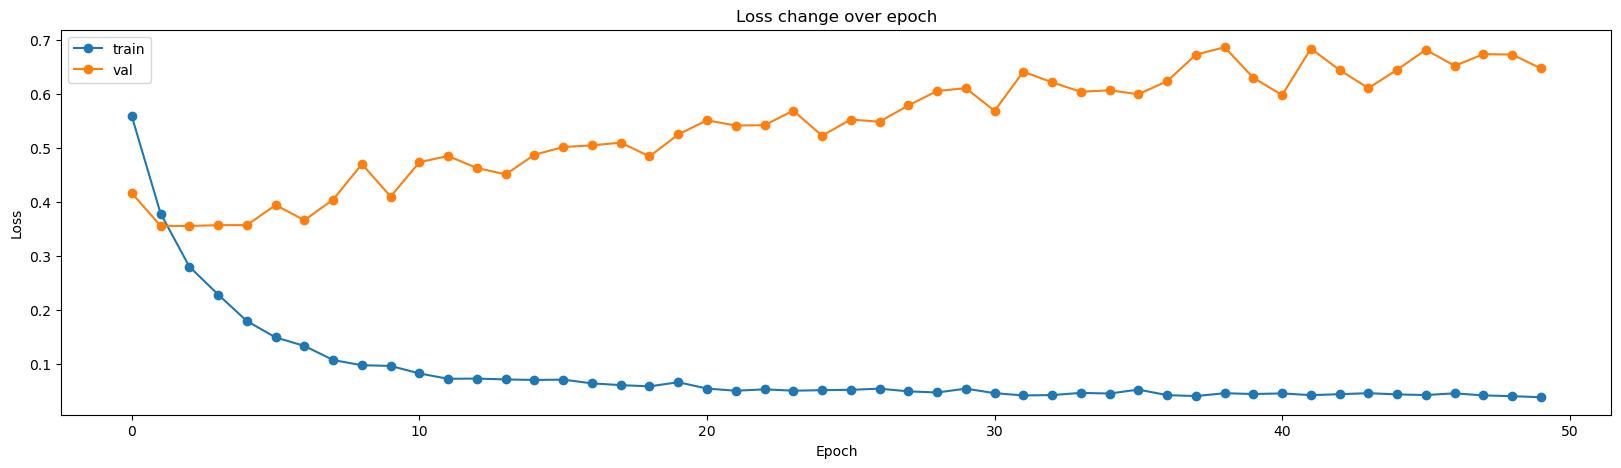

In [30]:
plt.figure(figsize=(20,5))
plt.plot(train_losses, '-o', label="train")
plt.plot(val_losses, '-o', label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss change over epoch")
plt.legend()

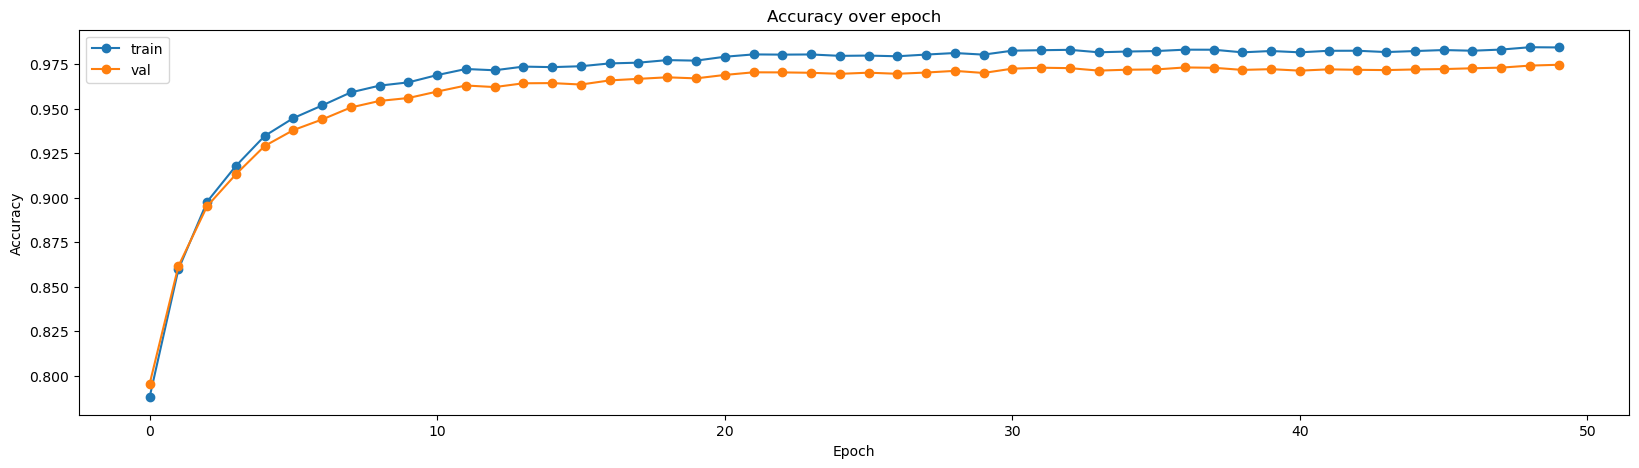

In [31]:
plt.figure(figsize=(20,5))
plt.plot(train_auc_epoch, '-o', label="train")
plt.plot(val_auc_epoch, '-o', label="val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over epoch")
plt.legend()